# Logistic Regression with Titanic Dataset

## [1. Import Libraries](#import-libraries)


## [2. Import Data](#import-data)

#### [Data Preprocessing](#preprocessing)

## [3. Clean Data (Replace NaN Values)](#clean-data)

## 4. Test Assumptions

- [Assumption 1: Absence of multicollinearity](#assumption-1) 
    
    - Test 1: Correlation Matrix
    - Test 2: VIF-Variance Inflation Factor 
    - Test 3: Check Residual Series

- [Assumption 2: Linearity of Independent Continuous Variables and Logit](#assumption-2)
    
    - Test 1: Box-Tidwell Test
    - Test 2: Visual Check 

- [Assumption 3: No Strongly Influential Outliers](#assumption-3)
    
    - Test 1: Cook's Distance (where any observation with Cook's Distance being greater than 4/n is influential) 
    - Test 2: Absolute Standardized Residuals to identify (std resid > 3) 

- [Assumption 4: Enough Data](#assumption-4)
    
    - Test 1: Enough Rows (at least 500)
    - Test 2: Enough Columns (at least 10, no more than 20)

- [Assumption 5: Correct Outcome Type](#assumption-5)
    
    - Test 2: Find output column data, check type of all unique data 

- [Assumption 6: Independence of Observations](#assumption-6)

    - Test 1: Check Residual Series
    - Test 2: Add a locally weighted scatterplot smoothing (LOWESS) line to better visualize independence


## References

- https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290


- https://github.com/kennethleungty/Logistic-Regression-Assumptions/blob/main/Logistic_Regression_Assumptions.ipynb



### Import Libraries
<a name='import-libraries'></a>

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.genmod import families
# linear model used in assumptions 2, 3, and 6
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Import Data 
<a name='import-data'></a>

In [119]:
df = pd.read_csv('data/titanic/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [120]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Data Preprocessing
<a name = 'preprocessing'><a/>

In [121]:
df_raw = pd.read_csv('data/titanic/train.csv')

# Create categorical variable for traveling alone
df_raw['TravelAlone'] = np.where((df_raw["SibSp"] + df_raw["Parch"])>0, 0, 1).astype('uint8')
df_raw.drop('SibSp', axis=1, inplace=True)
df_raw.drop('Parch', axis=1, inplace=True)
df_raw.drop('PassengerId', axis=1, inplace=True)
df_raw.drop('Name', axis=1, inplace=True)
df_raw.drop('Ticket', axis=1, inplace=True)
df_raw.drop('Cabin', axis=1, inplace=True)

# Create categorical variables and drop some variables
df_titanic = pd.get_dummies(df_raw, columns=["Pclass","Embarked","Sex"], 
                         drop_first=True) # Remove first variable to prevent collinearity

# Fill NaN (median imputation)
df_titanic["Age"].fillna(df_titanic["Age"].median(skipna=True), inplace=True)



### df_titanic

In [122]:
df_titanic.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,1,0,1,1
1,1,38.0,71.2833,0,0,0,0,0,0
2,1,26.0,7.9250,1,0,1,0,1,0
3,1,35.0,53.1000,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,1,0,1,1


### df_raw

In [123]:
df_raw.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,TravelAlone
0,0,3,male,22.0,7.2500,S,0
1,1,1,female,38.0,71.2833,C,0
2,1,3,female,26.0,7.9250,S,1
3,1,1,female,35.0,53.1000,S,0
4,0,3,male,35.0,8.0500,S,1


In [124]:
# Define dependent and independent variables
X_cols = df_titanic.columns.to_list()[1:]
X = df_titanic[X_cols]
y = df_titanic['Survived']

# Add constant
X = sm.add_constant(X, prepend=False)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Clean Data (Replace NaN Values)
<a name = 'clean-data'><a/>

In [125]:
df.Age.fillna(30,inplace=True,axis='index')
df.Cabin.fillna(df.Cabin.mode()[0],inplace=True,axis='index')
type(df.Embarked[0])
df.Embarked.fillna(df.Embarked.mode()[0],inplace=True,axis='index')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Test Assumptions

## Assumption 1: Absence of Multicollinearity 
<a name = 'assumption-1'><a/>

### [Test 1: Correlation Matrix](#correlation)
### [Test 2: Variance Inflation Factor](#vif)

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Correlation Matrix
<a name = 'correlation'><a/>

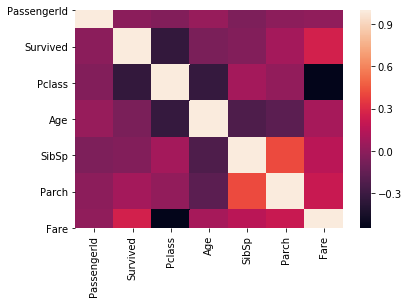

In [127]:
corr = df.corr()
sns.heatmap(corr)

### Variance Inflation Factor
<a name = 'vif'><a/>

In [128]:
# remove all negative values 

df.drop(['Name','Sex','Ticket','Cabin','Embarked'],inplace=True,axis='columns')
y = df[['Survived']]
x = df[['PassengerId','Pclass','Age','SibSp','Parch','Fare']]
# Use variance inflation factor to identify any significant multi-collinearity
# vif is 5
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(df)

,variables,VIF
0,PassengerId,3.676321
1,Survived,1.643124
2,Pclass,4.647909
3,Age,4.375130
4,SibSp,1.566763
5,Parch,1.558810
6,Fare,1.872241


In [129]:
# Avoid dropping first variables upon get_dummies
df_test = pd.get_dummies(df_raw, columns=["Pclass","Embarked","Sex"], 
                           drop_first=False)
df_test.drop('Sex_female', axis=1, inplace=True)
df_test["Age"].fillna(df_test["Age"].median(skipna=True), inplace=True)
calc_vif(df_test)

,variables,VIF
0,Survived,1.636129
1,Age,1.247705
2,Fare,1.690089
3,TravelAlone,1.223353
4,Pclass_1,117.152079
5,Pclass_2,99.102382
6,Pclass_3,260.025558
7,Embarked_C,69.936806
8,Embarked_Q,36.792002
9,Embarked_S,91.326578


## Assumption 2: Linearity Between Independent Continuous Variables and Logit
<a name = 'assumption-2'><a/>

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


### [Box-Tidwell Test](#box)

In [131]:
df_titanic_2 = df_titanic.drop(df_titanic[df_titanic.Age == 0].index)
df_titanic_2 = df_titanic_2.drop(df_titanic[df_titanic.Fare == 0].index)



### df_titanic_2

In [132]:
df_titanic_2

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
0,0,22.0,7.2500,0,0,1,0,1,1
1,1,38.0,71.2833,0,0,0,0,0,0
2,1,26.0,7.9250,1,0,1,0,1,0
3,1,35.0,53.1000,0,0,0,0,1,0
4,0,35.0,8.0500,1,0,1,0,1,1
5,0,28.0,8.4583,1,0,1,1,0,1
6,0,54.0,51.8625,1,0,0,0,1,1
7,0,2.0,21.0750,0,0,1,0,1,1
8,1,27.0,11.1333,0,0,1,0,1,0
9,1,14.0,30.0708,0,1,0,0,0,0


Logistic Regression with statsmodel - Inclusion of interaction term (logit transform) as part of Box-Tidwell test

In [133]:
df_titanic_lt = df_titanic_2.copy()

# Define continuous variables
continuous_var = ['Age', 'Fare']

# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in continuous_var:
    df_titanic_lt[f'{var}:Log_{var}'] = df_titanic_lt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_titanic_lt.head()

,Survived,Age,Fare,TravelAlone,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,Age:Log_Age,Fare:Log_Fare
0,0,22.0,7.2500,0,0,1,0,1,1,68.002934,14.362261
1,1,38.0,71.2833,0,0,0,0,0,0,138.228274,304.141753
2,1,26.0,7.9250,1,0,1,0,1,0,84.710510,16.404927
3,1,35.0,53.1000,0,0,0,0,1,0,124.437182,210.922595
4,0,35.0,8.0500,1,0,1,0,1,1,124.437182,16.789660


In [134]:
# Keep columns related to continuous variables
cols_to_keep = continuous_var + df_titanic_lt.columns.tolist()[-len(continuous_var):]
cols_to_keep

['Age', 'Fare', 'Age:Log_Age', 'Fare:Log_Fare']

In [135]:
# Redefine independent variables to include interaction terms
X_lt = df_titanic_lt[cols_to_keep]
y_lt = df_titanic_lt['Survived']

# Add constant
X_lt = sm.add_constant(X_lt, prepend=False)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_lt, X_lt, family=families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  876
Model:                            GLM   Df Residuals:                      871
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -536.19
Date:                Wed, 08 Dec 2021   Deviance:                       1072.4
Time:                        09:06:54   Pearson chi2:                     881.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age              -0.1123      0.058     -1.948

### [Visual Check](#visual)

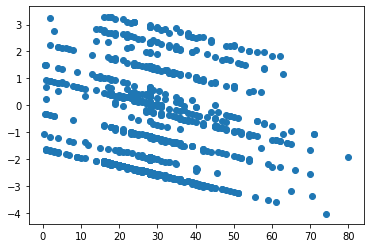

In [136]:
# Re-run logistic regression on original set of X and y variables
logit_results = GLM(y, X, family=families.Binomial()).fit()
predicted = logit_results.predict(X)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

# Visualize predictor continuous variable vs logit values (Age)
plt.scatter(x = df_titanic['Age'].values, y = log_odds);
plt.show()

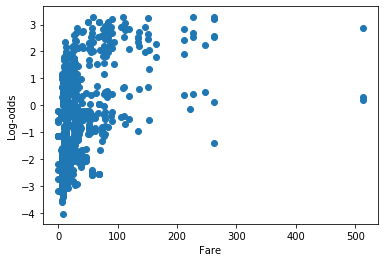

In [137]:
# Visualize predictor variable vs logit values for Fare
plt.scatter(x = df_titanic['Fare'].values, y = log_odds);
plt.xlabel("Fare")
plt.ylabel("Log-odds")
plt.show()

In [140]:
#df = df.drop(['PassengerId','Pclass','Name','Sex','SibSp','Parch','Ticket','Cabin','Embarked'],axis = 'columns')
df['Log_Age'] = df.Age.apply(lambda x: x * np.log(x))
df['Log_Fare'] = df.Fare.apply(lambda x: x * np.log(x))

In [143]:
df

,PassengerId,Pclass,Age,SibSp,Parch,Fare,const,Log_Age,Log_Fare
0,1,3,22.0,1,0,7.2500,1.0,68.002934,14.362261
1,2,1,38.0,1,0,71.2833,1.0,138.228274,304.141753
2,3,3,26.0,0,0,7.9250,1.0,84.710510,16.404927
3,4,1,35.0,1,0,53.1000,1.0,124.437182,210.922595
4,5,3,35.0,0,0,8.0500,1.0,124.437182,16.789660
5,6,3,30.0,0,0,8.4583,1.0,102.035921,18.059724
6,7,1,54.0,0,0,51.8625,1.0,215.405139,204.784059
7,8,3,2.0,3,1,21.0750,1.0,1.386294,64.238444
8,9,3,27.0,0,2,11.1333,1.0,88.987595,26.830592
9,10,2,14.0,1,0,30.0708,1.0,36.946803,102.347610


In [142]:
df.drop(df[df.Fare == 0].index,inplace=True)
df.drop(df[df.Age == 0].index,inplace=True)
df = sm.add_constant(df,prepend=False)
y = df.Survived
#df.drop('Survived',inplace=True,axis=1)

AttributeError: 'DataFrame' object has no attribute 'Survived'

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876 entries, 0 to 890
Data columns (total 5 columns):
Age         876 non-null float64
Fare        876 non-null float64
Log_Age     876 non-null float64
Log_Fare    876 non-null float64
const       876 non-null float64
dtypes: float64(5)
memory usage: 41.1 KB


## Assumption 3: No Strongly Influential Outliers
<a name = 'assumption-2'><a/>

In [104]:
# Use GLM method for logreg here so that we can retrieve the influence measures
logit_model = GLM(y, X, family=families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      882
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -398.95
Date:                Wed, 08 Dec 2021   Deviance:                       797.91
Time:                        08:54:01   Pearson chi2:                     933.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Age            -0.0333      0.008     -4.397      

In [105]:
# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(logit_results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df

,cooks_d,std_resid
0,0.000041,0.330871
1,0.000046,0.243040
2,0.001006,0.866265
3,0.000091,0.313547
4,0.000017,0.280754
5,0.000166,0.395867
6,0.000409,0.605037
7,0.000185,0.451230
8,0.000988,0.912978
9,0.000084,0.265096


In [106]:
# Set Cook's distance threshold
cook_threshold = 4 / len(df_titanic)
print(f"Threshold for Cook Distance = {cook_threshold}")

Threshold for Cook Distance = 0.004489337822671156


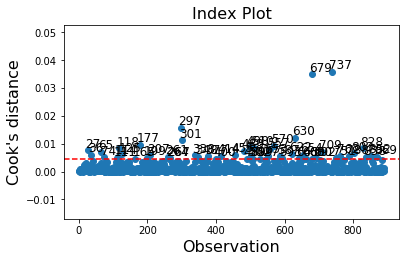

In [107]:
# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y = cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

In [108]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(df_titanic)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 6.1%


In [109]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(df_titanic)),1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')

Proportion of highly influential outliers = 1.3%


In [110]:
# Display top 5 most influential outliers
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
297,0.015636,4.951289
570,0.009277,3.030644
498,0.008687,3.384369
338,0.005917,4.461842
414,0.005666,4.387731


In [111]:
# Deep dive into index 297 (extreme outlier)
df_titanic.iloc[297]

Survived         0.00
Age              2.00
Fare           151.55
TravelAlone      0.00
Pclass_2         0.00
Pclass_3         0.00
Embarked_Q       0.00
Embarked_S       1.00
Sex_male         0.00
Name: 297, dtype: float64

## Assumption 4: Enough Data
<a name = 'assumption-4'><a/>

In [42]:
# for satisfaction: 10-20 columns, 500+ rows
print("Number of columns:\n" , len(df.columns) , "\n")
print("Number of rows:\n",len(df),"\n")

Number of columns:
 12 

Number of rows:
 876 



## Assumption 5: Correct Outcome Type
<a name = 'assumption-5'><a/>

In [68]:
# for binary classification satisfaction: 2 outputs (0 and 1) 
print("Number of unique outcomes:\n" , y.nunique())
print("The different outcomes: \n" , y.unique()[0] ,"\n" , y.unique()[1])

Number of unique outcomes:
 2
The different outcomes: 
 0 
 1


## Assumption 6: Independence of Observations
<a name = 'assumption-6'><a/>
 
### [Test 1: Check Residual Series](#residual)
### [Test 2: Add a locally weighted scatterplot smoothing line to visualize independence ](#lowess)

### Check Residual Series
<a name = 'residual'><a/>

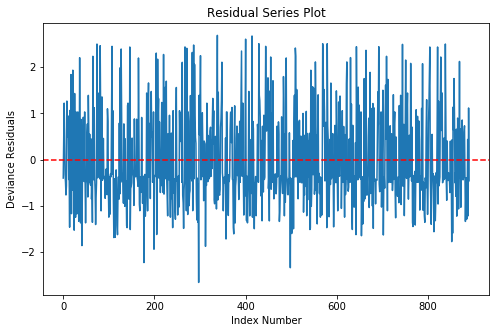

In [113]:
# Generate residual series plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
    xlabel="Index Number", ylabel="Deviance Residuals")

# ax.plot(df_titanic_2.index.tolist(), stats.zscore(logit_results.resid_pearson))
ax.plot(df_titanic.index.tolist(), stats.zscore(logit_results.resid_deviance))
plt.axhline(y = 0, ls="--", color='red');

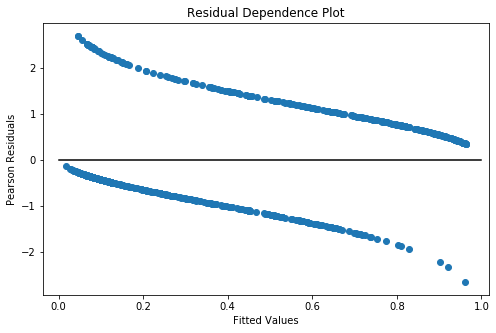

In [114]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(
    111,
    title="Residual Dependence Plot",
    xlabel="Fitted Values",
    ylabel="Pearson Residuals",
)
# ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_pearson))
ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_deviance))
ax.axis("tight")
ax.plot([0.0, 1.0], [0.0, 0.0], "k-");

### Test 2: Add a locally weighted scatterplot smoothing (LOWESS) line to better visualize independence
<a name = 'lowess'><a/>

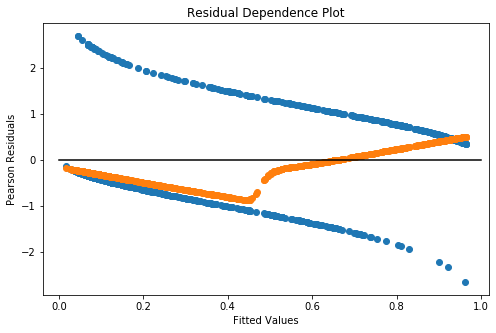

In [117]:
# Setup LOWESS function
lowess = sm.nonparametric.lowess

# Get y-values from LOWESS (set return_sorted=False)
y_hat_lowess = lowess(logit_results.resid_pearson, logit_results.mu, 
                      return_sorted = False,
                      frac=2/3)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111,
    title="Residual Dependence Plot",
    xlabel="Fitted Values",
    ylabel="Pearson Residuals",
)
# ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_pearson))
ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_deviance))
ax.scatter(logit_results.mu, y_hat_lowess)
ax.axis("tight")
ax.plot([0.0, 1.0], [0.0, 0.0], "k-");

## References

- https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290


- https://github.com/kennethleungty/Logistic-Regression-Assumptions/blob/main/Logistic_Regression_Assumptions.ipynb